In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import pandas as pd
from PIL import Image
import numpy as np
from torchmetrics.functional import structural_similarity_index_measure
import kornia


torch.manual_seed(42)

device = torch.device("mps" if torch.cuda.is_available() else "cpu")

def rgblab(rgb_tensor):
    lab_tensor = kornia.color.rgb_to_lab(rgb_tensor)
    lab_tensor[:, 0, :, :] = lab_tensor[:, 0, :, :] / 100.0
    #lab_tensor[:, 1:, :, :] = lab_tensor[:, 1:, :, :] + 128
    lab_tensor[:, 1:, :, :] = (lab_tensor[:, 1:, :, :] + 128) / 255.0
    return lab_tensor


def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

def create_model():
    model = CNNModel(3, 256, 256,50)
    # Apply the weights initialization to the model
    model.apply(weights_init)
    return model.to(device)


class CNNModel(nn.Module):
    def __init__(self, channels, height, width, batch_size):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(channels, 16, kernel_size=5, stride=2, padding=2)
        self.leakyrelu1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.leakyrelu2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.leakyrelu3 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(p=0.15)

        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(64)
        self.leakyrelu4 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(p=0.15)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(64)
        self.leakyrelu5 = nn.LeakyReLU()
        self.dropout5 = nn.Dropout(p=0.15)

        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.batchnorm6 = nn.BatchNorm2d(64)
        self.leakyrelu6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.leakyrelu7 = nn.LeakyReLU()
        self.dropout7 = nn.Dropout(p=0.15)

        self.conv7 = nn.Conv2d(64, 16, kernel_size=1, stride=1)
        self.leakyrelu8 = nn.LeakyReLU()

        self.dropout8 = nn.Dropout(p=0.15)
        self.fc1 = nn.Linear(64, 32)
        self.relu9 = nn.ReLU()
        self.fc2 = nn.Linear(32, 3 * 10)

        for param in self.parameters():
            param.requires_grad_(True)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.leakyrelu1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.leakyrelu2(x)

        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.leakyrelu3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = self.leakyrelu4(x)
        x = self.dropout4(x)

        x = self.conv5(x)
        x = self.batchnorm5(x)
        x = self.leakyrelu5(x)
        x = self.dropout5(x)

        x = self.conv6(x)
        x = self.batchnorm6(x)
        x = self.leakyrelu6(x)

        x = self.avgpool(x)
        x = self.leakyrelu7(x)
        x = self.dropout7(x)

        x = self.conv7(x)
        x = self.leakyrelu8(x)

        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.relu9(x)
        x = self.fc2(x)

        # Reshape the output to (batch_size, 3, 10)
        x = x.view(batch_size, 3, 10)

        return x

def changevalues(input_ten):
    tensor_min = input_ten.min()
    tensor_max = input_ten.max()

    # Scale the tensor values to the range of 0 to 1 using torch.div()
    scaled_tensor = torch.div(input_ten - tensor_min, tensor_max - tensor_min)
    return scaled_tensor  

def color_basis_vector(p):
    R, G, B = p
    R_squared = R**2
    G_squared = G**2
    B_squared = B**2
    R_mult_G = R * G
    G_mult_B = G * B
    B_mult_R = B * R
    
    return [R, G, B, R_squared, G_squared, B_squared, R_mult_G, G_mult_B, B_mult_R, 1]

def transform_image(inputs, outputs):
    batch_size, channel, height, width = inputs.shape
    transformed_image = torch.zeros_like(inputs)

    for bs in range(batch_size):
        pixels = inputs[bs].reshape(channel, -1)
        basis_vector = torch.tensor([color_basis_vector(pixel) for pixel in pixels.T])
        transformed_pixels = (torch.matmul(outputs[bs], basis_vector.T) + pixels) / 2

        transformed_image[bs] = transformed_pixels.reshape(channel, height, width)
    
    transformed_image_clamp = changevalues(transformed_image)
    return transformed_image_clamp


def train(model, train_dataloader, num_epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.SGD(model.parameters(), learning_rate, momentum=0.9)
    model.to(device)
    prev_weights=None
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_clamp = changevalues(labels)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            output_image = transform_image(inputs, outputs)
            output_image_torch = output_image.to(device)
            
            output_lab=rgblab(output_image_torch)
            labels_lab=rgblab(labels_clamp)
            
            loss = criterion(output_lab, labels_lab)
            # Assuming you have the 'criterion' defined and the tensors 'output_image_torch' and 'labels_clamp'
            print(output_image_torch.shape)
            #loss = 1 - structural_similarity_index_measure(output_image_torch, labels_clamp)

            #for name, param in model.named_parameters():
            #    print(f'{name}: requires_grad={param.requires_grad}, grad_fn={param.grad_fn}')
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f}")
        # Check if weights have changed after each epoch
        if prev_weights is not None:
            weight_changed = False
            for prev_param, param in zip(prev_weights, model.parameters()):
                if not torch.allclose(prev_param, param):
                    weight_changed = True
                    break

            if weight_changed:
                print("Model weights have changed.")
            else:
                print("Model weights have not changed.")

        # Update previous weights
        prev_weights = [param.detach().clone() for param in model.parameters()]
        

def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)
    

class ImageDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_path = self.data.iloc[idx, 0]
        output_path = input_path
    
        input_image = Image.open('/Users/madarapusrikar/Documents/CSC528/project/output/expert_dani_raw/'+input_path+'.png')
        output_image = Image.open('/Users/madarapusrikar/Documents/CSC528/project/output/expert_dani/'+output_path+'.jpg')
        
        input_image = self.transform(input_image)
        output_image = self.transform(output_image)
        return input_image, output_image



In [2]:
# Set the paths and parameters
csv_file = "dani_data.csv"
save_path = "pce5_3_model_2.pt"

batch_size = 50
num_classes = 30

dataset = ImageDataset(csv_file)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = create_model()
train(model, train_dataloader, num_epochs=5, learning_rate=0.000005)

save_model(model, save_path)

torch.Size([50, 3, 256, 256])
torch.Size([26, 3, 256, 256])
Epoch 1/5 | Loss: 0.0164
torch.Size([50, 3, 256, 256])
torch.Size([26, 3, 256, 256])
Epoch 2/5 | Loss: 0.0147
Model weights have changed.
torch.Size([50, 3, 256, 256])
torch.Size([26, 3, 256, 256])
Epoch 3/5 | Loss: 0.0131
Model weights have changed.
torch.Size([50, 3, 256, 256])
torch.Size([26, 3, 256, 256])
Epoch 4/5 | Loss: 0.0119
Model weights have changed.
torch.Size([50, 3, 256, 256])
torch.Size([26, 3, 256, 256])
Epoch 5/5 | Loss: 0.0111
Model weights have changed.


In [3]:
model.eval()

CNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (leakyrelu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu3): LeakyReLU(negative_slope=0.01)
  (dropout3): Dropout(p=0.15, inplace=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu4): LeakyReLU(negative_slope=0.01)
  (dropout4): Dropout(p=0.15, inplace=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchnorm5): BatchNorm2d(64, eps=1e-0

In [4]:
from PIL import Image
import torchvision.transforms as transforms


#image_title="a1487-20081226_at_16h52m49__MG_3920"
#image_title="a0232-MB_20030906_040"
image_title="a1694-CRW_0172"

#png_filename = "/Users/madarapusrikar/Documents/CSC528/project/output/expert_dani_raw/a1487-20081226_at_16h52m49__MG_3920.png"
png_filename = "/Users/madarapusrikar/Documents/CSC528/project/output/expert_dani_raw/"


input_image1 = Image.open(png_filename+image_title+".png")

width, height = input_image1.size

transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])


input_tensor = transform(input_image1)

desired_shape = (1, 3,256, 256)
input_tensor = input_tensor.reshape(desired_shape)
input_tensor = input_tensor.to(device)


output_tensor = model(input_tensor)

print(output_tensor)

tensor([[[-0.1007,  0.4793, -0.0549, -0.2091,  0.1345, -0.1365,  0.1397,
          -0.0273, -0.2107,  0.2045],
         [ 0.0697,  0.1416, -0.0866, -0.0131, -0.1094, -0.0291,  0.1596,
          -0.0117,  0.1704,  0.2181],
         [-0.0254,  0.3710, -0.0052,  0.2212, -0.0879, -0.0052,  0.2198,
          -0.2312,  0.0199, -0.0880]]], grad_fn=<ViewBackward0>)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [5]:
import numpy as np
transformed_image = transform_image(input_tensor, output_tensor)

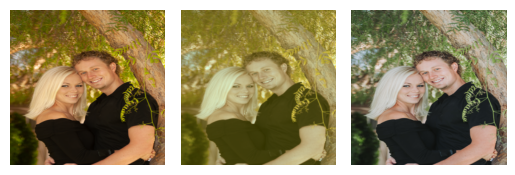

In [6]:
import matplotlib.pyplot as plt



tensor_img = transformed_image

# Convert the tensor to a numpy array
image_array = tensor_img.cpu().squeeze().permute(1, 2, 0).detach().numpy()


#actual_ouput_image_png_filename = "/Users/madarapusrikar/Documents/CSC528/project/output/expert_dani/a1487-20081226_at_16h52m49__MG_3920.jpg"
#actual_ouput_image_png_filename = "/Users/madarapusrikar/Documents/CSC528/project/output/expert_dani/a1694-CRW_0172.jpg"
actual_ouput_image_png_filename = "/Users/madarapusrikar/Documents/CSC528/project/output/expert_dani/"

actual_ouput_image =Image.open(actual_ouput_image_png_filename+image_title+".jpg")



fig, axs = plt.subplots(1, 3)

axs[0].imshow(input_image1.resize((256, 256)))
axs[0].axis('off')

axs[1].imshow(image_array)
axs[1].axis('off')

axs[2].imshow(actual_ouput_image.resize((256, 256)))
axs[2].axis('off')

plt.subplots_adjust(wspace=0.1)
plt.show()




In [ ]:
def display_images(inputs, outputs):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        # Display input image
        input_img = np.transpose(inputs[i], (1, 2, 0))
        axes[0, i].imshow(input_img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Input')
        
        # Display output image
        output_img = np.transpose(outputs[i], (1, 2, 0))
        axes[1, i].imshow(output_img)
        axes[1, i].axis('off')
        axes[1, i].set_title('Target')
    
    plt.tight_layout()
    plt.show()

In [ ]:
display_dataloader = dataset
count = 0
inputs = []
outputs = []
for image, label in display_dataloader:
    inputs.append(image)
    outputs.append(label)
    count += 1
    if count == 5:
        display_images(inputs, outputs)
        break

### Model Arch

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, channels, height, width):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(channels, 16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc = nn.Linear(64 * (height // 8) * (width // 8), 30)

        for param in self.parameters():
            param.requires_grad_(True)

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.maxpool3(x)

        x = x.view(batch_size, -1)
        x = self.fc(x)

        # Reshape the output to (batch_size, 3, 10)
        x = x.view(batch_size, 3, 10)

        return x


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, channels, height, width):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(32 * (height // 4) * (width // 4), 30)
        
        for param in self.parameters():
            param.requires_grad_(True)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)
        
        x = x.view(batch_size, -1)
        x = self.fc(x)
        
        # Reshape the output to (batch_size, 3, 10)
        x = x.view(batch_size, 3, 10)
        
        return x

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, channels, height, width):
        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = nn.Linear(64 * (height // 8) * (width // 8), 30)
        
        for param in self.parameters():
            param.requires_grad_(True)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.maxpool3(x)
        
        x = x.view(batch_size, -1)
        x = self.fc(x)
        
        # Reshape the output to (batch_size, 3, 10)
        x = x.view(batch_size, 3, 10)
        
        return x